<h1><b>Import Libraries<b><h1>

In [41]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import pandas_datareader as pdr
import tensorflow
import keras
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import time
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.svm import SVR, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

<h1><b>Input Data from Yahoo Finance<b><h1>

In [42]:
import yfinance as yf

ticker = 'ICICIBANK.NS'
start_date = '2022-01-01'
end_date = '2023-11-30'

DF = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [43]:
DF

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,743.049988,766.000000,743.000000,764.700012,753.932556,9653095
2022-01-04,767.950012,778.000000,763.599976,772.849976,761.967773,12114437
2022-01-05,773.000000,795.849976,771.200012,788.049988,776.953796,19741360
2022-01-06,775.049988,792.500000,774.000000,785.049988,773.996033,13018067
2022-01-07,792.200012,802.299988,786.250000,793.250000,782.080566,12250210
...,...,...,...,...,...,...
2023-11-22,923.250000,925.200012,914.750000,922.750000,922.750000,12197979
2023-11-23,923.000000,925.349976,918.500000,923.000000,923.000000,5534614
2023-11-24,921.500000,930.400024,920.200012,929.400024,929.400024,7452002


<h1><b>Plotting closing price for every day<b><h1>

Text(0, 0.5, 'Value')

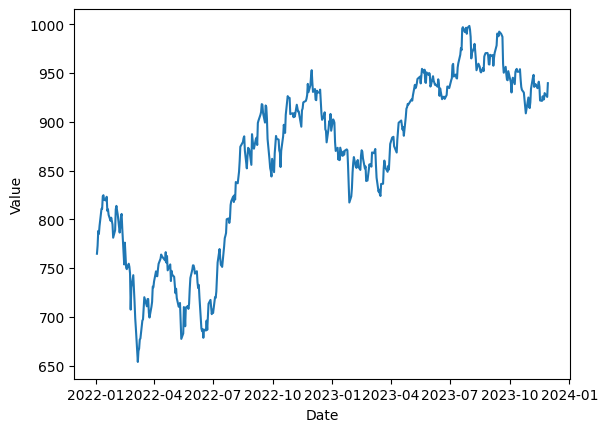

In [44]:
plt.plot(DF.Close)
plt.xlabel('Date')
plt.ylabel('Value')

<h1><b>Define Function<b></h1>

In [45]:
#creating datasets from the dataframe, make data stationary:
def difference_pct_back(datafile, lag = 1):
    diff = [0] * lag
    for i in range(lag,len(datafile)):
        diff.append(datafile[i]/datafile[i-lag]-1)
    return diff

def create_dataset_percentage_gap(dataset, window_size, look_forward, gap): #MinMaxScaler(feature_range=(0, 1))
    i = 0
    data_X, data_Y = [], []
    while i in range(len(dataset) - window_size - look_forward):
        a = dataset[i:(i + window_size), :]
        data_X.append(a)
        b = dataset[i + window_size + look_forward-1, 0]/dataset[i+window_size-1,0]-1
        data_Y.append(b)
        i += gap

    x = np.array(data_X)
    y = np.array(data_Y)
    y = y.reshape(-1,1)
    return (x,y)

def create_dataset_difference_gap(dataset, window_size, look_forward, gap): #MinMaxScaler(feature_range=(0, 1))
    i = 0
    data_X, data_Y = [], []
    while i in range(len(dataset) - window_size - look_forward):
        a = dataset[i:(i + window_size), :]
        data_X.append(a)
        b = dataset[i + window_size + look_forward-1, 0]-dataset[i+window_size-1,0]
        data_Y.append(b)
        i += gap

    x = np.array(data_X)
    y = np.array(data_Y)
    y = y.reshape(-1,1)
    return (x,y)

#regression to classification:
def y_classifier(array, threshold):
    classes = []
    for i in range(len(array)):
        if array[i,0] > threshold:
            classes.append(1)
        elif array[i,0] < -1*threshold:
            classes.append(-1)
        else:
            classes.append(0)
    return np.asarray(classes)

#defining moving averages:
def EMA(df, EMA_days):
    sma = np.mean(df[0:EMA_days])
    EMA_list = [0] * (EMA_days - 1)
    EMA_list.append(sma)
    c = 2/(1+EMA_days)
    for i in range(EMA_days,len(df)):
        a = EMA_list[i-1]*(1-c)+ c*df[i]
        EMA_list.append(a)
    return(EMA_list)

def SMA(df, sma_days):
    sma_list = [0] * (sma_days - 1)
    for i in range(sma_days, len(df)+1):
        sma_list.append(np.mean(df[i-sma_days:i]))
    return(sma_list)

#defining some metrics
def rms(y, pred):
    temp = 0
    if len(y) != len(pred):
        return False
    else:
        for i in range(len(y)):
            temp += (y[i][0] - pred[i][0])**2
        return temp/len(y)

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)+0.0000000001))

def mae(A, F):
    return 1/len(A) * np.sum(np.abs(F - A))

#autocorrelation benchmark:
def benchmark(y, look_forward):
    Y_hat = []
    Y_real = []
    for i in range(2*look_forward, len(y)):
        a = np.mean(y[i-2*look_forward:i-look_forward,0])
        Y_hat.append(a)
        Y_real.append(y[i,0])
    return (np.asarray(Y_real), np.asarray(Y_hat))

def pretty_print_conf_matrix(y_true, y_pred, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

def plot(y_train, prediction_train,y_test, prediction_test):
    fig = plt.figure()
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, prediction_train)
    plt.ylabel('predicted')
    plt.xlabel('actual')
    plt.title('ML-Train')


    plt.subplot(1, 2, 2)
    plt.scatter(y_test, prediction_test)
    plt.ylabel('predicted')
    plt.xlabel('actual')
    plt.title('ML-Test')
    plt.show()

    plt.figure(figsize=(15,8))
    plt.subplot(2, 1, 1)
    plt.plot(prediction_train, marker = '*',linestyle="None", label = 'Pred')
    plt.plot(y_train, marker = '.', label = 'Y', linestyle="None")
    plt.grid()
    plt.legend()
    plt.title('Train')
    plt.subplots_adjust(hspace = 0.4)

    plt.subplot(2, 1, 2)
    plt.plot(prediction_test, marker = '*', label = 'Pred',linestyle="None")
    plt.plot(y_test, marker = '.',linestyle="None" , label = 'Y')
    plt.grid()
    plt.legend()
    plt.title('Test')

#this function changes 1D y array to an array with 3 features that is used for softmax
def y_softmax(array):
    lst = []
    for i in range(len(array)):
        if array[i] == 1:
            lst.append([1,0,0])
        elif array[i] == 0:
            lst.append([0,1,0])
        else:
            lst.append([0,0,1])
    return np.asarray(lst)


def softmaxifier(array):
    zeros = [0, 0, 0]
    pred = []
    for i in range(len(array)):
        j = np.argmax(array[i])
        temp = [0,0,0]
        temp[j] = 1
        pred.append(temp)
    return pred

#this function changes 3D y array with 3 features that was generated by softmax to an 1D array for confusion matrix
def desoftmaxer(array):
    lst = []
    for i in range(len(array)):
        if np.argmax(array[i]) == 0:
            lst.append(1)
        elif np.argmax(array[i]) == 1:
            lst.append(0)
        else:
            lst.append(-1)
    return (np.asarray(lst))
#fix random effect
def fix_rnd_Keras():
    seed_value= 0
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    import random
    random.seed(seed_value)
    import numpy as np
    np.random.seed(seed_value)
    import tensorflow as tf
    tf.set_random_seed(seed_value)
    from keras import backend as K
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

#split x and y to test and train that are devisible to batch_size
def test_train_split(x, y, batch_size, train_ratio):
    train_length = int(len(x)*train_ratio)
    for i in range(train_length, train_length+batch_size):
        remainder = i%batch_size
        if remainder == 0:
            train_length = i
            break
    x_train = x[:train_length,:]
    y_train = y[:train_length]

    for i in range(len(x)-batch_size, len(x)):
        remainder = i%batch_size
        if remainder == 0:
            train_length_test = i
            break
    x_test = x[train_length:train_length_test,:]
    y_test = y[train_length:train_length_test]
    return x_train, y_train, x_test, y_test

<h1><b>Creating Features<b></h1>

In [46]:
df = DF.Close
df = df.dropna(axis=0, how='any')

#making moving averages
v_10 = SMA(DF.Volume, 10)
v_20 = SMA(DF.Volume, 20)
open_close = (DF.Close/DF.Open - 1).tolist()
high_low = (DF.High/DF.Low - 1).tolist()
EMA_8 = EMA(df,8)
SMA_10 = SMA(df,10)
SMA_20 = SMA(df,20)
SMA_50 = SMA(df,50)
SMA_100 = SMA(df,100)
pct_day = difference_pct_back(df, 1)
list_df = df.tolist()
vol_list = DF.Volume.tolist()
MAs = pd.DataFrame(list(zip(list_df, pct_day, vol_list, v_10, v_20,open_close,high_low, EMA_8, SMA_10,
                            SMA_20, SMA_50, SMA_100)),columns=['spot', 'pct_day', 'vol', 'v_10', 'v_20',
                            'open_close', 'high_low', 'EMA_8', 'SMA_10', 'SMA_20', 'SMA_50','SMA_100'])

#removing all rows with 0 in them
MAs = MAs[100:]
MAs = MAs.reset_index(drop=True)

#making differences as features
MAs['v10'] = MAs.vol/MAs.v_10 - 1
MAs['v20'] = MAs.vol/MAs.v_20 - 1
MAs['spot_EMA'] = MAs.spot/MAs.EMA_8 - 1
MAs['spot_20SMA'] = MAs.spot/MAs.SMA_20 - 1
MAs['spot_50SMA'] = MAs.spot/MAs.SMA_50 - 1
MAs['spot_100SMA'] = MAs.spot/MAs.SMA_100 - 1
MAs['10_100_SMA'] = MAs.SMA_10/MAs.SMA_100 - 1
MAs['20_50_SMA'] = MAs.SMA_20/MAs.SMA_50 - 1
MAs = MAs.drop(['EMA_8', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'v_10', 'v_20'], 1)

C:\Users\soham\AppData\Local\Temp\ipykernel_19700\1380255108.py:34: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  MAs = MAs.drop(['EMA_8', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'v_10', 'v_20'], 1)


<h1><b>Visualisation<b></h1>

,spot,pct_day,vol,open_close,high_low,v10,v20,spot_EMA,spot_20SMA,spot_50SMA,spot_100SMA,10_100_SMA,20_50_SMA
0,752.849976,0.005812,20272212,0.015992,0.021877,0.536849,0.563855,0.029634,0.054139,0.032436,0.007799,-0.034917,-0.020588
1,752.650024,-0.000266,10102092,0.006217,0.015318,-0.223959,-0.214302,0.022688,0.051767,0.031241,0.007804,-0.028590,-0.019516
2,749.750000,-0.003853,10949759,-0.001731,0.011504,-0.120243,-0.154386,0.014521,0.046183,0.026171,0.004436,-0.020128,-0.019129
3,744.299988,-0.007269,8563791,-0.015672,0.021317,-0.294184,-0.328557,0.005549,0.036767,0.017984,-0.002321,-0.014934,-0.018117
4,746.750000,0.003292,9107831,0.008849,0.015346,-0.194005,-0.274676,0.006877,0.037549,0.020541,0.001587,-0.009532,-0.016393


<Figure size 640x480 with 0 Axes>

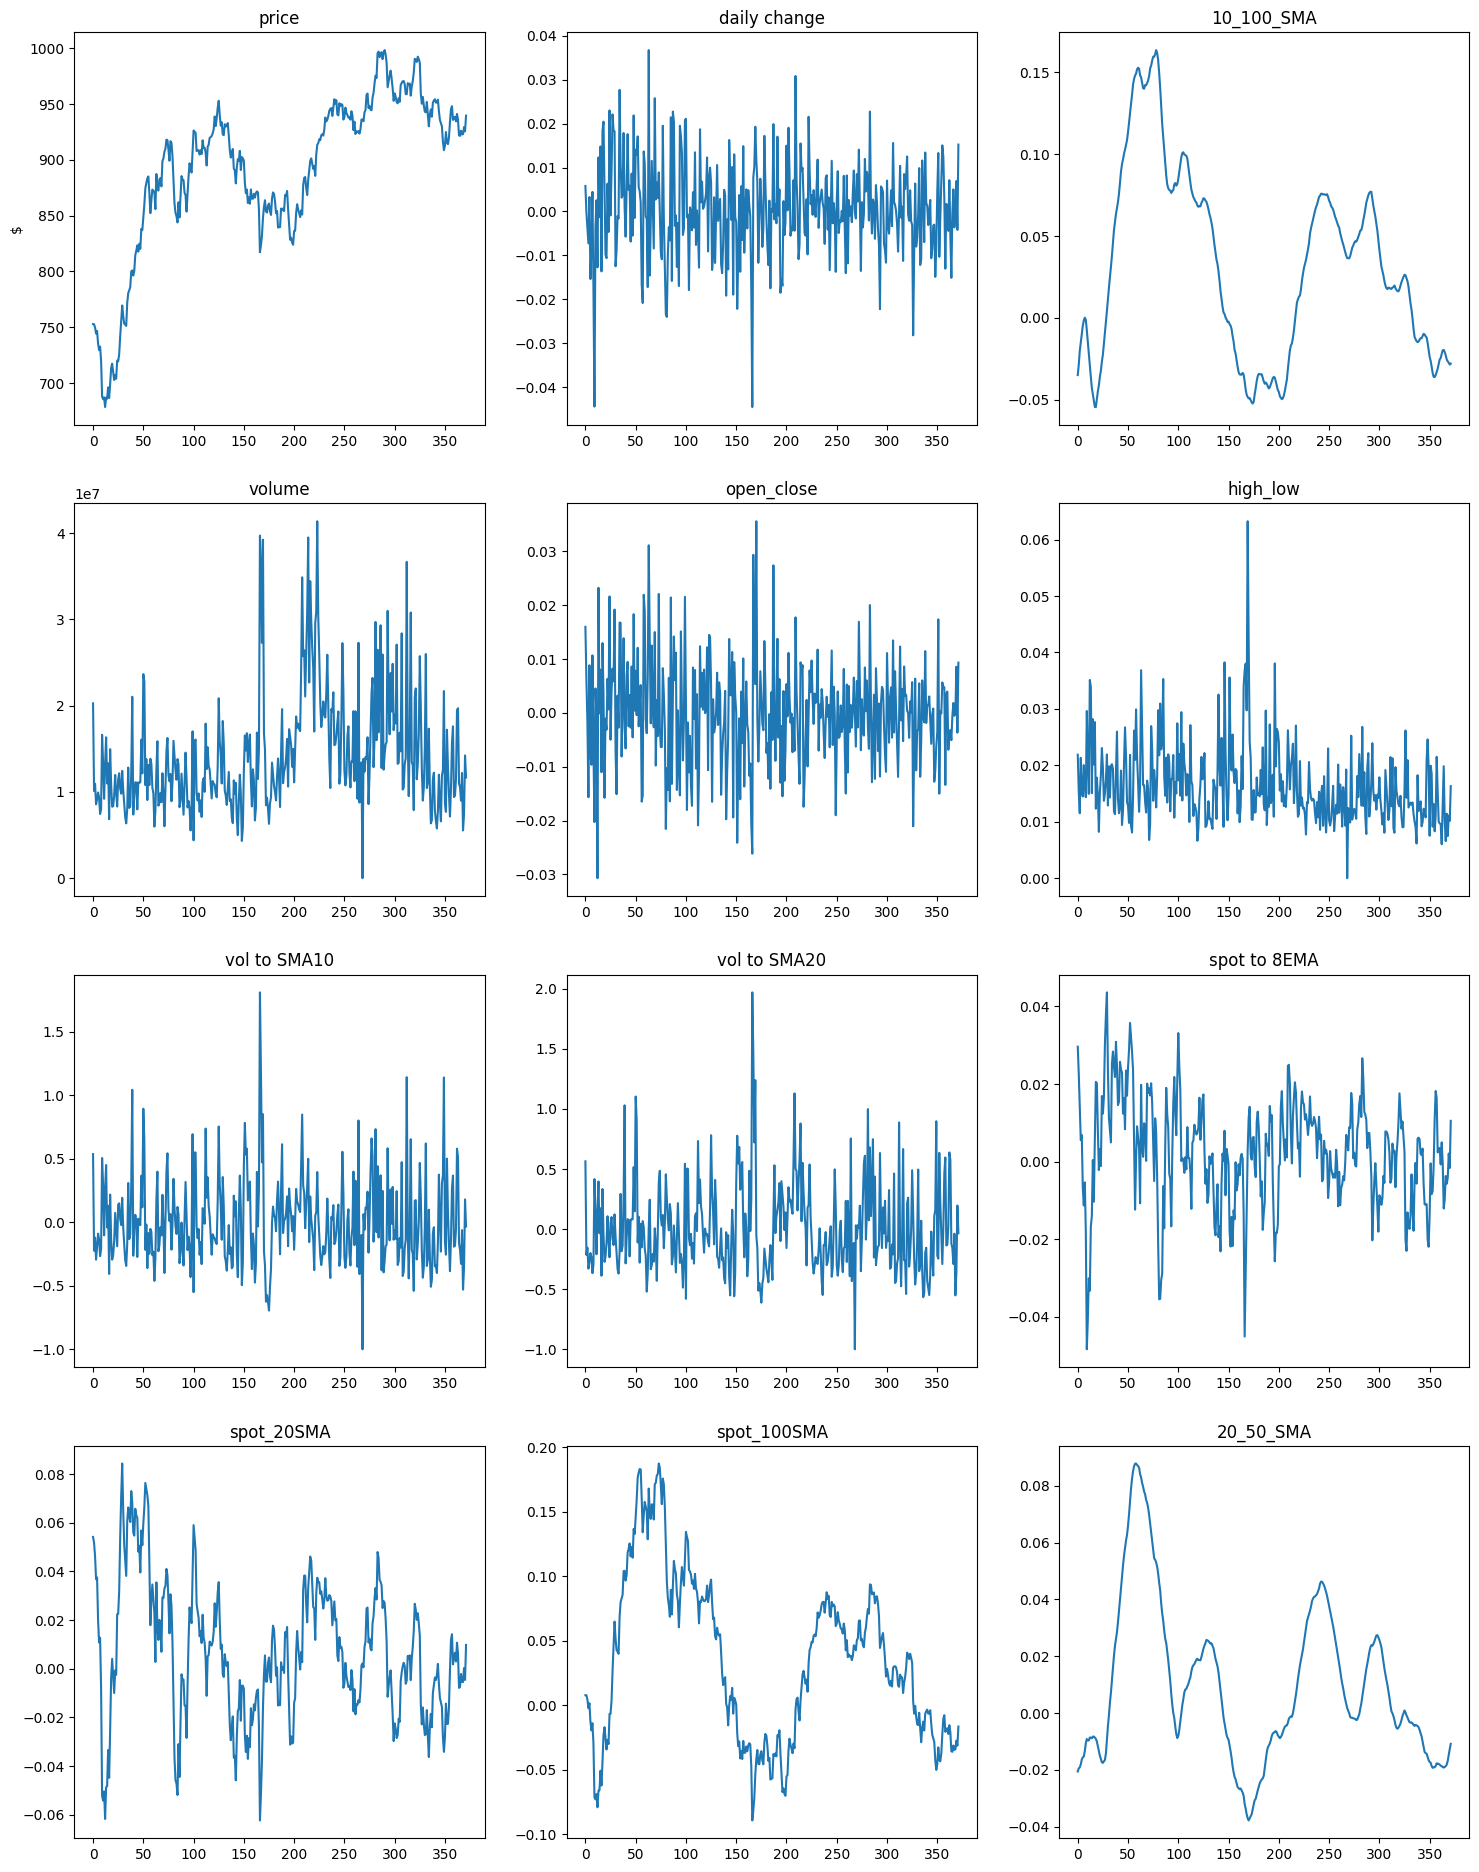

In [47]:
fig = plt.figure()
plt.figure(figsize=(18,14))

plt.subplot(4, 3, 1)
plt.plot(MAs.spot)
plt.ylabel('$')
plt.title('price')

plt.subplot(4, 3, 2)
plt.plot(MAs.pct_day)
plt.title('daily change')

plt.subplot(4, 3, 3)
plt.plot(MAs['10_100_SMA'])
plt.title('10_100_SMA')

plt.subplot(4, 3, 4)
plt.plot(MAs.vol)
plt.title('volume')
plt.subplots_adjust(top = 1.4)

plt.subplot(4, 3, 5)
plt.plot(MAs.open_close)
plt.title('open_close')

plt.subplot(4, 3, 6)
plt.plot(MAs.high_low)
plt.title('high_low')

plt.subplot(4, 3, 7)
plt.plot(MAs.v10)
plt.title('vol to SMA10')

plt.subplot(4, 3, 8)
plt.plot(MAs.v20)
plt.title('vol to SMA20')

plt.subplot(4, 3, 9)
plt.plot(MAs.spot_EMA)
plt.title('spot to 8EMA')

plt.subplot(4, 3, 10)
plt.plot(MAs.spot_20SMA)
plt.title('spot_20SMA')

plt.subplot(4, 3, 11)
plt.plot(MAs.spot_100SMA)
plt.title('spot_100SMA')

plt.subplot(4, 3, 12)
plt.plot(MAs['20_50_SMA'])
plt.title('20_50_SMA')
MAs.head(5)

<h1><b>Opening Price Prediction<b><h1>

In [48]:
import math
import numpy as np
import pandas as pd
import pandas_datareader as web
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [49]:
import yfinance as yf
import datetime

ticker = 'ICICIBANK.NS'
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime(2023, 11, 30)

df = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [50]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,743.049988,766.000000,743.000000,764.700012,753.932556,9653095
2022-01-04,767.950012,778.000000,763.599976,772.849976,761.967834,12114437
2022-01-05,773.000000,795.849976,771.200012,788.049988,776.953796,19741360
2022-01-06,775.049988,792.500000,774.000000,785.049988,773.996033,13018067
2022-01-07,792.200012,802.299988,786.250000,793.250000,782.080566,12250210
...,...,...,...,...,...,...
2023-11-22,923.250000,925.200012,914.750000,922.750000,922.750000,12197979
2023-11-23,923.000000,925.349976,918.500000,923.000000,923.000000,5534614
2023-11-24,921.500000,930.400024,920.200012,929.400024,929.400024,7452002


In [51]:
df.shape

(472, 6)

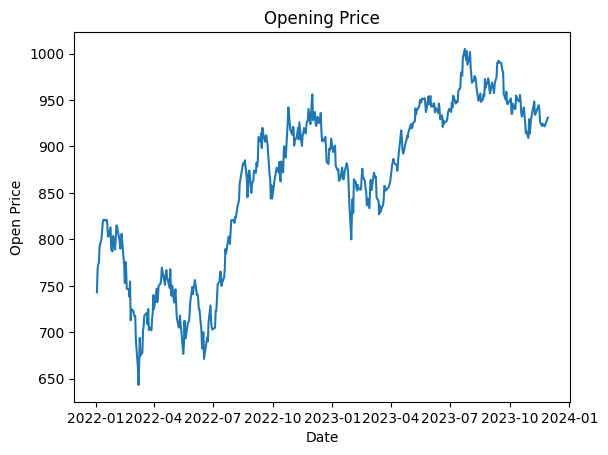

In [52]:
plt.figure()
plt.title('Opening Price')
plt.plot(df['Open'])
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.show()

In [53]:
data=df.filter(['Open'])

#Convert to np array
dataset=data.values

#Get the number of rows to train the model on
#math.ceil to round up

training_data_len = math.ceil(len(dataset)*.8)

#print(dataset)
training_data_len

378

In [54]:
#Scale the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [55]:
#Create training dataset
#Create scaled training dataset

train_data = scaled_data[0:training_data_len,:]

#Split the data into x_train and y_train data set

x_train=[]
y_train=[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.27581914, 0.34467031, 0.35863405, 0.36430248, 0.41172408,
       0.43398314, 0.46025163, 0.48472273, 0.49135905, 0.49135905,
       0.48859395, 0.49135905, 0.47753353, 0.44158717, 0.44158717,
       0.46923822, 0.40287572, 0.39706906, 0.443661  , 0.40273749,
       0.43896029, 0.47476842, 0.47214154, 0.46038985, 0.42789987,
       0.40564082, 0.42568782, 0.44974426, 0.42458172, 0.35586894,
       0.30319374, 0.36609986, 0.34066087, 0.28632651, 0.28466751,
       0.26296151, 0.30775606, 0.19245135, 0.22577083, 0.22024062,
       0.20378821, 0.20544721, 0.1318955 , 0.05585514, 0.        ,
       0.0591733 , 0.1400526 , 0.08668612, 0.09622559, 0.1609291 ,
       0.17586073, 0.20600026, 0.21484863, 0.18069966, 0.22590905,
       0.16355598, 0.17060696, 0.16231165, 0.1963224 , 0.21498685])]
[0.2671091665971903]



In [56]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [57]:
#Reshape the data into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(318, 60, 1)

<h1><b>Model Training<b></h1>

In [58]:
#Build LSTM model
model=Sequential()
#Add first layer to model
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
#Add second layer to model
model.add(LSTM(50, return_sequences=False))
#Add Dense Layer to model with 25 neurons
model.add(Dense(25))
#Add Dense Layer to model with 1 neuron
model.add(Dense(1))

In [59]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [60]:
#Train the model
model.fit(x_train, y_train, batch_size=1,epochs=25)

Epoch 1/25
318/318 [==============================] - 10s 21ms/step - loss: 0.0097
Epoch 2/25
318/318 [==============================] - 6s 20ms/step - loss: 0.0042
Epoch 3/25
318/318 [==============================] - 6s 19ms/step - loss: 0.0038
Epoch 4/25
318/318 [==============================] - 6s 19ms/step - loss: 0.0027
Epoch 5/25
318/318 [==============================] - 6s 20ms/step - loss: 0.0023
Epoch 6/25
318/318 [==============================] - 6s 19ms/step - loss: 0.0024
Epoch 7/25
318/318 [==============================] - 6s 20ms/step - loss: 0.0027
Epoch 8/25
318/318 [==============================] - 11s 35ms/step - loss: 0.0019
Epoch 9/25
318/318 [==============================] - 13s 41ms/step - loss: 0.0019
Epoch 10/25
318/318 [==============================] - 14s 43ms/step - loss: 0.0017
Epoch 11/25
318/318 [==============================] - 13s 42ms/step - loss: 0.0017
Epoch 12/25
318/318 [==============================] - 14s 44ms/step - loss: 0.0016
Epoch 1

<h1><b>Testing and Validating Model<b><h1>

In [61]:
#Create the test data set
#Create a new array containing scaled values

test_data=scaled_data[training_data_len-60: , : ]
#Create the data sets x_test and y_test

x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [62]:
#Convert the data to a numpy array

x_test=np.array(x_test)

In [63]:
#Reshape the data to 3d
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [64]:
#Get the models predicted price values

predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

3/3 [==============================] - 1s 16ms/step


In [104]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse =np.sqrt(np.mean(predictions-y_test)**2)



print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
mape = mean_absolute_percentage_error(y_test, predictions)
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Squared Error: 578.4654783459499
Mean Absolute Error: 22.573599957405253
Root Mean Squared Error: 22.573599957405253
Mean Absolute Percentage Error (MAPE): 2.350798619682628


C:\Users\soham\AppData\Local\Temp\ipykernel_19700\3856801789.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


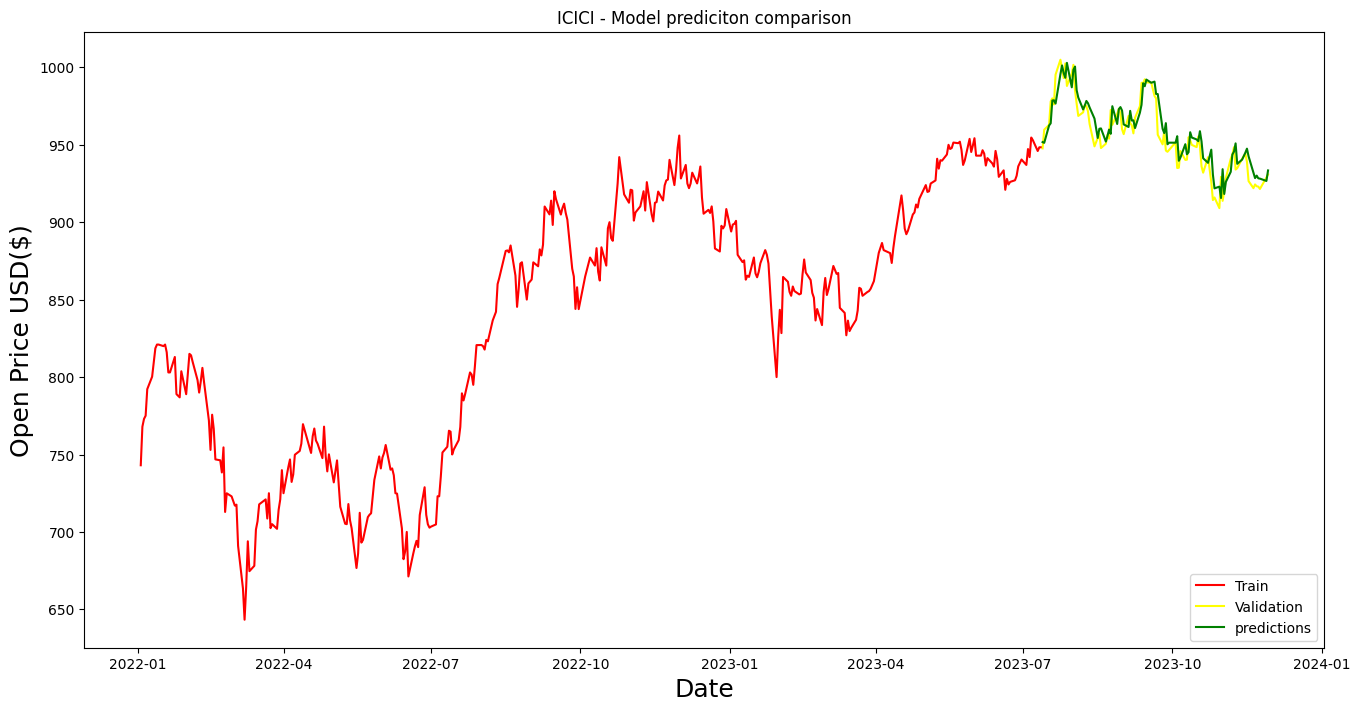

In [66]:
#plot the data

train=data[:training_data_len]
valid=data[training_data_len:]
valid['predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('ICICI - Model prediciton comparison')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD($)', fontsize=18)
plt.plot(train['Open'] , color='red')
plt.plot(valid['Open'] , color='yellow')
plt.plot(valid[ 'predictions'] , color='green')
plt.legend(['Train','Validation', 'predictions'], loc='lower right')
plt.show()

In [67]:
#Show the valid and predicted prices

valid.tail(30)

,Open,predictions
Date,,
2023-10-16,948.500000,953.447754
2023-10-17,955.400024,952.373413
2023-10-18,949.200012,958.781372
2023-10-19,936.000000,952.155823
2023-10-20,932.000000,941.276611
2023-10-23,942.000000,938.356445
2023-10-25,926.049988,946.846497
2023-10-26,914.299988,930.803406
2023-10-27,916.000000,921.869385


<h1><b>Getting Predictions for Tomorrow<b></h1>

In [102]:
#Get the quote
ticker = 'ICICIBANK.NS'
start_date = '2022-01-01'
end_date = '2023-11-30'
stock_quote = yf.download(ticker, start=start_date, end=end_date)

new_df=stock_quote.filter(['Open'])
#Get last 60 days values and convert into array
last_60_days=new_df[-60:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Opening Price of {ticker} tomorrow:{pred_price}')

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 33ms/step
Opening Price of ICICIBANK.NS tomorrow:[[912.449]]


<h1><b>Getting Predictions for 60 days from now<b></h1>

In [70]:
import yfinance as yf
import numpy as np

# Assuming you already have the 'model' and 'scaler' objects defined

# Get historical stock data
ticker = 'ICICIBANK.NS'
start_date = '2022-01-01'
end_date = '2023-11-30'
stock_quote = yf.download(ticker, start=start_date, end=end_date)

# Extract 'Open' prices
new_df = stock_quote.filter(['Open'])

# Take the last 60 days of 'Open' prices and scale them
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list to store predicted prices
predicted_prices = []

# Number of days to forecast (adjust as needed)
forecast_days = 60

# Loop through the forecast period
for _ in range(forecast_days):
    # Reshape the data for prediction
    X_test = np.array([last_60_days_scaled])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Get predicted scaled price
    pred_price = model.predict(X_test)

    # Undo the scaling
    pred_price = scaler.inverse_transform(pred_price)

    # Append the predicted price to the list
    predicted_prices.append(pred_price[0, 0])

    # Update last_60_days for the next iteration
    last_60_days = np.append(last_60_days[1:], pred_price, axis=0)
    last_60_days_scaled = scaler.transform(last_60_days)

# Print the predicted prices for the next 2 months
for i, price in enumerate(predicted_prices, 1):
    print(f'Day {i}: Predicted Opening Price of {ticker}: {price}')


[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 32ms/step
Day 1: Predicted Opening Price of ICICIBANK.NS: 934.6266479492188
Day 2: Predicted Opening Price of ICICIBANK.NS: 938.3831787109375
Day 3: Predicted Opening Price of ICICIBANK.NS: 941.7423095703125
Day 4: Predicted Opening Price of ICICIBANK.NS: 944.87939453125
Day 5: Predicted Opening Price of ICICIBANK.NS: 947.8402709960938
Day 6: Predicted Opening Price of ICICIBANK.NS: 950.6390991210938
Day 7: Predicted Opening Price of ICICIBANK.NS: 953.2846069335938
Day 8: Predicted Opening Price of ICICIBANK.NS: 955.7850952148438
Day 9: Predicted Opening Price of ICICIBANK.NS: 958.1497802734375
Day 10: Predicted Opening Price of ICICIBANK.NS: 960.3882446289062
Day 11: Predicted Opening Price of ICICIBANK.NS: 962.5100708007812
Day 12: Predicted Opening Price of ICICIBANK.NS: 964.5242309570312
Day 13: Predicted Opening Price of ICICIBANK.NS: 966.4390258789062
Day 14: Predicted O

<h1><b>Closing Price Prediction<b></h1>

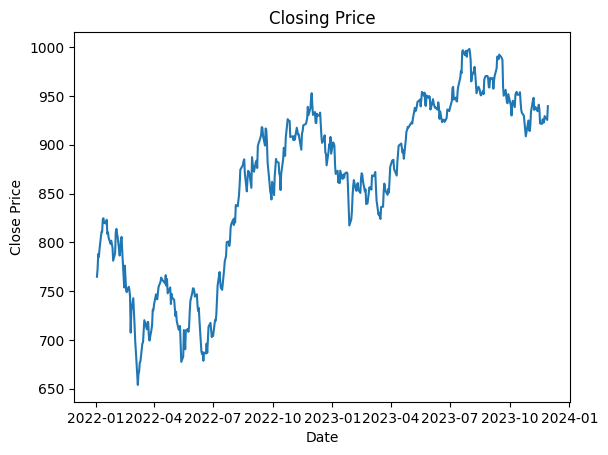

In [71]:
plt.figure()
plt.title('Closing Price')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [72]:
data=df.filter(['Close'])

#Convert to np array
dataset=data.values

#Get the number of rows to train the model on
#math.ceil to round up

training_data_len = math.ceil(len(dataset)*.8)


#print(dataset)
training_data_len

378

In [73]:
#Scale the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.32201427],
       [0.3456682 ],
       [0.38978375],
       [0.38107674],
       [0.40487594],
       [0.45566683],
       [0.45537667],
       [0.4933972 ],
       [0.49615446],
       [0.48251344],
       [0.48048177],
       [0.49151061],
       [0.44942673],
       [0.45421566],
       [0.43752722],
       [0.41996812],
       [0.42925564],
       [0.40893928],
       [0.36975774],
       [0.39196051],
       [0.45436074],
       [0.46437384],
       [0.45044266],
       [0.43912347],
       [0.38499501],
       [0.40269919],
       [0.43259322],
       [0.44042956],
       [0.39776518],
       [0.29008857],
       [0.35495572],
       [0.32012768],
       [0.28036563],
       [0.27615739],
       [0.29226532],
       [0.28312289],
       [0.2636772 ],
       [0.15571042],
       [0.22144824],
       [0.25816287],
       [0.17733269],
       [0.12929905],
       [0.09955011],
       [0.        ],
       [0.03265129],
       [0.03976205],
       [0.06631832],
       [0.070

In [74]:
#Create training dataset
#Create scaled training dataset

train_data = scaled_data[0:training_data_len,:]

#Split the data into x_train and y_train data set

x_train=[]
y_train=[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.32201427, 0.3456682 , 0.38978375, 0.38107674, 0.40487594,
       0.45566683, 0.45537667, 0.4933972 , 0.49615446, 0.48251344,
       0.48048177, 0.49151061, 0.44942673, 0.45421566, 0.43752722,
       0.41996812, 0.42925564, 0.40893928, 0.36975774, 0.39196051,
       0.45436074, 0.46437384, 0.45044266, 0.43912347, 0.38499501,
       0.40269919, 0.43259322, 0.44042956, 0.39776518, 0.29008857,
       0.35495572, 0.32012768, 0.28036563, 0.27615739, 0.29226532,
       0.28312289, 0.2636772 , 0.15571042, 0.22144824, 0.25816287,
       0.17733269, 0.12929905, 0.09955011, 0.        , 0.03265129,
       0.03976205, 0.06631832, 0.0700915 , 0.12305914, 0.1265418 ,
       0.15745175, 0.19256995, 0.16543318, 0.18705562, 0.18734578,
       0.14642291, 0.13205631, 0.16427217, 0.17863878, 0.22391533])]
[0.2221738223916747]



In [75]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [76]:
#Reshape the data into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(318, 60, 1)

<h1><b>Model Training<b></h1>

In [77]:
#Build LSTM model
model=Sequential()
#Add first layer to model
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
#Add second layer to model
model.add(LSTM(50, return_sequences=False))
#Add Dense Layer to model with 25 neurons
model.add(Dense(25))
#Add Dense Layer to model with 1 neuron
model.add(Dense(1))

In [78]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [106]:
#Train the model
model.fit(x_train, y_train, batch_size=1,epochs=30 )

Epoch 1/30
318/318 [==============================] - 6s 19ms/step - loss: 0.0013
Epoch 2/30
318/318 [==============================] - 6s 19ms/step - loss: 0.0012
Epoch 3/30
318/318 [==============================] - 6s 19ms/step - loss: 0.0013
Epoch 4/30
318/318 [==============================] - 5s 17ms/step - loss: 0.0011
Epoch 5/30
318/318 [==============================] - 6s 18ms/step - loss: 0.0012
Epoch 6/30
318/318 [==============================] - 6s 19ms/step - loss: 0.0012
Epoch 7/30
318/318 [==============================] - 6s 18ms/step - loss: 0.0012
Epoch 8/30
318/318 [==============================] - 6s 18ms/step - loss: 0.0012
Epoch 9/30
318/318 [==============================] - 6s 20ms/step - loss: 0.0011
Epoch 10/30
318/318 [==============================] - 6s 20ms/step - loss: 0.0011
Epoch 11/30
318/318 [==============================] - 6s 20ms/step - loss: 0.0011
Epoch 12/30
318/318 [==============================] - 6s 20ms/step - loss: 0.0011
Epoch 13/30
3

<h1><b>Testing and Validating Model<b></h1>

In [107]:
#Create the test data set
#Create a new array containing scaled values

test_data=scaled_data[training_data_len-60: , : ]
#Create the data sets x_test and y_test

x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [108]:
#Convert the data to a numpy array

x_test=np.array(x_test)

In [109]:
#Reshape the data to 3d
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [110]:
#Get the models predicted price values

predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)


3/3 [==============================] - 0s 10ms/step


In [111]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse =np.sqrt(np.mean(predictions-y_test)**2)



print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
mape = mean_absolute_percentage_error(y_test, predictions)
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Squared Error: 151.5360352146895
Mean Absolute Error: 10.423209332405253
Root Mean Squared Error: 9.166122761178524
Mean Absolute Percentage Error (MAPE): 1.0830170399089216


C:\Users\soham\AppData\Local\Temp\ipykernel_19700\3539927776.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


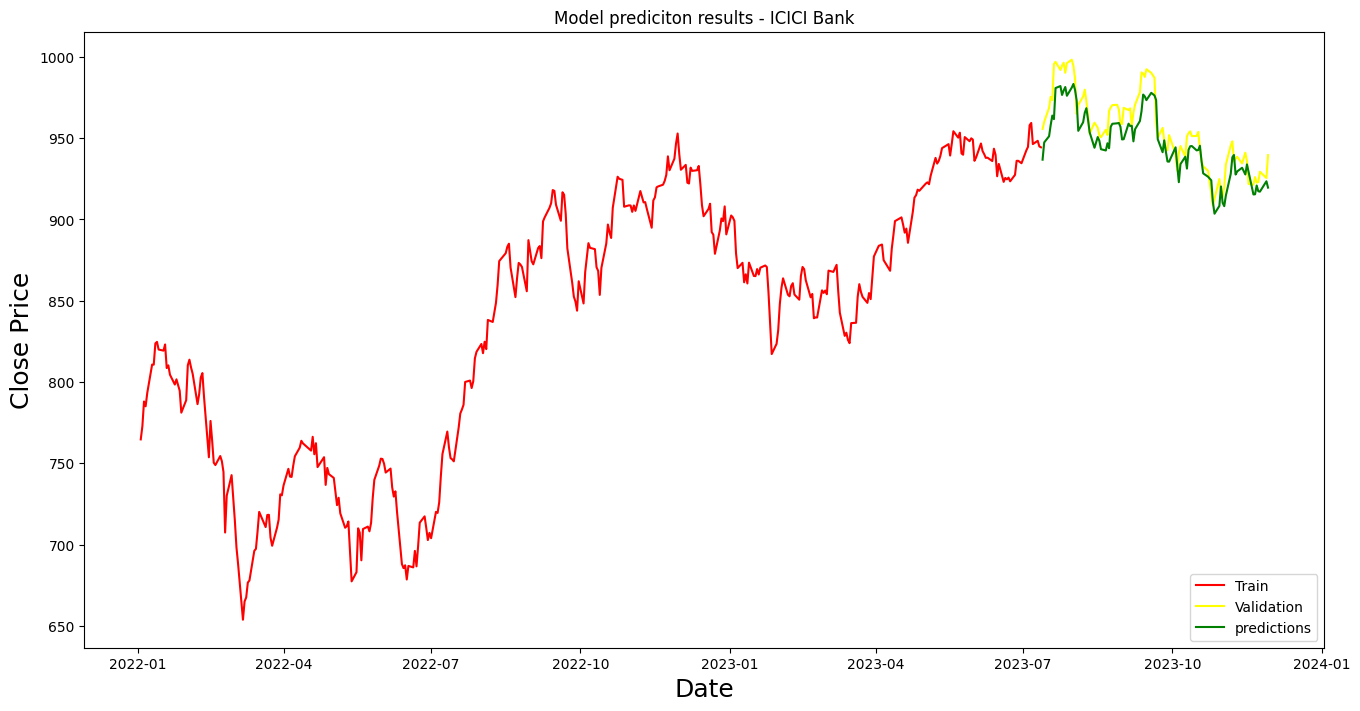

In [112]:
#plot the data
train=data[:training_data_len]
valid=data[training_data_len:]
valid['predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model prediciton results - ICICI Bank')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'] , color='red')
plt.plot(valid['Close'] , color='yellow')
plt.plot(valid[ 'predictions'] , color='green')
plt.legend(['Train','Validation', 'predictions'], loc='lower right')
plt.show()

In [113]:
#Show the valid and predicted prices

valid.tail(20)

,Close,predictions
Date,,
2023-10-31,915.349976,920.332886
2023-11-01,914.049988,910.223999
2023-11-02,919.950012,908.185852
2023-11-03,933.799988,914.733154
2023-11-06,945.450012,928.038025
2023-11-07,948.099976,938.294983
2023-11-08,935.750000,939.689941
2023-11-09,937.349976,927.653870
2023-11-10,938.599976,929.575867


<h1><b>Getting Predictions for Tomorrow<b></h1>

In [114]:
#Get the quote
ticker = 'ICICIBANK.NS'
start_date = '2022-01-01'
end_date = '2023-11-30'
stock_quote = yf.download(ticker, start=start_date, end=end_date)

new_df=stock_quote.filter(['Close'])
#Get last 60 days values and convert into array
last_60_days=new_df[-60:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Price of {ticker} tomorrow:{pred_price}')

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 46ms/step
Price of ICICIBANK.NS tomorrow:[[932.6548]]


<h1><b>Getting Predictions for 60 days from now<b></h1>

In [115]:
import yfinance as yf
import numpy as np

# Assuming you have the necessary imports and the 'model' and 'scaler' objects are defined

# Get the historical stock data
ticker = 'ICICIBANK.NS'
start_date = '2022-01-01'
end_date = '2023-11-30'
stock_quote = yf.download(ticker, start=start_date, end=end_date)

# Extract 'Close' prices
new_df = stock_quote.filter(['Close'])

# Take the last 60 days of 'Close' prices and scale them
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list to store predicted prices
predicted_prices = []

# Number of days to forecast (adjust as needed)
forecast_days = 60

# Loop through the forecast period
for _ in range(forecast_days):
    # Reshape the data for prediction
    X_test = np.array([last_60_days_scaled])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Get predicted scaled price
    pred_price = model.predict(X_test)

    # Undo the scaling
    pred_price = scaler.inverse_transform(pred_price)

    # Append the predicted price to the list
    predicted_prices.append(pred_price[0, 0])

    # Update last_60_days for the next iteration
    last_60_days = np.append(last_60_days[1:], [pred_price[0]], axis=0)
    last_60_days_scaled = scaler.transform(last_60_days)

# Print the predicted prices for the next 60 days
for i, price in enumerate(predicted_prices, 1):
    print(f'Day {i}: Predicted Closing Price of {ticker}: {price}')


[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 21ms/step
Day 1: Predicted Closing Price of ICICIBANK.NS: 932.65478515625
Day 2: Predicted Closing Price of ICICIBANK.NS: 926.16357421875
Day 3: Predicted Closing Price of ICICIBANK.NS: 919.1671752929688
Day 4: Predicted Closing Price of ICICIBANK.NS: 913.1876831054688
Day 5: Predicted Closing Price of ICICIBANK.NS: 907.9395141601562
Day 6: Predicted Closing Price of ICICIBANK.NS: 903.18701171875
Day 7: Predicted Closing Price of ICICIBANK.NS: 898.75537109375
Day 8: Predicted Closing Price of ICICIBANK.NS: 894.5401611328125
Day 9: Predicted Closing Price of ICICIBANK.NS: 890.482177734375
Day 10: Predicted Closing Price of ICICIBANK.NS: 886.5473022460938
Day 11: Predicted Closing Price of ICICIBANK.NS: 882.7144775390625
Day 12: Predicted Closing Price of ICICIBANK.NS: 878.9689331054688
Day 13: Predicted Closing Price of ICICIBANK.NS: 875.2988891601562
Day 14: Predicted Closing 